In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 


3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# gdf = gpd.read_file("../data/iris/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("../data/iris/gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("../data/iris/gdf.pickle", "rb") as f:
    gdf_france = pickle.load(f)
    geojson=gdf_france.__geo_interface__
    len(gdf_france)

In [3]:
years = list(range(20,26))
spe_df = pd.read_sql("select id, label, label_long from specialite", config.connection_string, index_col="id")
spe_df.T

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
label,Psychiatre,Anest,Dermato,Gastro,Gyneco,Opthtalmo,Pediatre,Radio,Dentiste,Generaliste,Cardio,Chirugien,Endocrino,Geriatre,Neuro,ORL,Pneumo,Radiotherapeuthe,Rhumato,Stomato,Infirmier
label_long,Psychiatre,Anesthésiste,Dermatologue,Gastro-entérologue,Gynécologue,Opthtalmogue,Pédiatre,Radiologue,Dentiste,Généraliste,Cardiologue,Chirugien,Endocrinologue,Gériatre,Neurologue,Oto-rhino-laryngologiste,Pneumologue,Radiothérapeuthe,Rhumatologue,Stomatologue,Infirmier


Documentation

code_commune: il y a plusieurs possibilités :
* le code de la commune sur 5 chiffres, par exemple "06088" pour Nice
* certains anciens code commune sont accepté comme 75101 pour Paris 1er arrondissement
* le département sur 2 chiffres, par exemple "06"
* le code IRIS sur 9 chiffres, par exemple "382050000"
* une liste de code IRIS entre crochet, par exemple \["385480000", "382050000"]
* une liste de code commune entre crochet, par exemple \["38548", "38205"]
* le code IRIS avec un joker de type "3820%"
* pour la corse utiliser les préfixes 2A ou 2B et non 20, par exemple "2A004"

specialite: voir tableau ci dessus

source: "PA" pour ps_libreacces ou "PS"

time: 30 ou 45, il est possible d'en faire d'autre mais il faut lancer les calculs

time_type: "HC" ou "HP"

aexp: -0.12 ou -0.1 ou -0.08 ou -0.06 ou -0.04<br>
Pour time==30 aexp: -0.12 ou -0.1 ou -0.08<br>
Pour time==45 aexp: -0.08 ou -0.06<br>
Pour time==60 aexp: -0.06 ou -0.04

norm_colorbar = True si normalisé sur les quantiles de la France, sinon False

Puis appuyer sur le bouton Restart (bouton avec double flèche à droite FFW)

In [98]:
code_commune=["38548", "38205"] #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "38548" "2A004" "382050000" ["385480000", "382050000"] ["38548", "38205"] "45" "14581" bug
specialite = 10
source="PA" # PA or PS
time=30 # 30 or 45
time_type="HC" # HC or HP
aexp=-0.12 # -0.12 or -0.1 or -0.08 or -0.06 or -0.04
norm_colorbar = True
code_commune,specialite,source,time,time_type,aexp,norm_colorbar

(['38548', '38205'], 10, 'PA', 30, 'HC', -0.12, True)

In [99]:
if type(code_commune) is list:
    if len(code_commune[0])==5:
        type_code="CLIST"
    elif  len(code_commune[0])==9:
        type_code = "ILIST"
    else:
        raise ValueError(f"Bad {code_commune}")    
elif "%" in code_commune and len(code_commune) > 2:
    type_code = "LIKE"
elif len(code_commune) == 2:
    type_code = "LIKE"
    code_commune = code_commune + "%"
elif len(code_commune) == 5:
    type_code = "COM"
elif len(code_commune) == 9:
    type_code = "IRIS"
else:
    raise ValueError(f"Bad {code_commune}")
print(f"Type code: {type_code}")

Type code: CLIST


In [100]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
commune_nom = None
if type_code=="COM":
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
elif type_code in ["IRIS", "LIKE"]:
    iriss = [code_commune]
elif type_code == "ILIST":
    iriss = code_commune
elif type_code == "CLIST":
    sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code in {tuple(code_commune)}
"""
    print(sql)
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
print(f"Found {len(iriss)} iris for {commune_nom}")

if type_code == "LIKE":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(code_commune[:-1])]
elif len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"
if commune_nom is None:
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)


select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code in ('38548', '38205')

Found 2 iris for Lans-en-Vercors
Found 2 geo iris for Lans-en-Vercors, type_code: CLIST


,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
30007,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972
47432,IRIS____0000000385480000,38548,Villard-de-Lans,0000,385480000,Villard-de-Lans,Z,"MULTIPOLYGON (((5.49422 45.07174, 5.49498 45.0...",47432,5.543924,45.060117


In [101]:
def get_study_by_year(year):
    sql = f"""
    select * from apl.apl_study s
    where s.specialite_id={specialite}
    and s.year={year}
    and s.source='{source}'
    and s.time={time}
    and s.time_type='{time_type}'
    and s.exp={aexp}
    order by date desc
    limit 1
    """
    return pd.read_sql(sql, config.connection_string)

def get_studies_by_years(years: list[int]):
    df = None
    for year in years:
        if df is None:
            df = get_study_by_year(year)
        else:
            df = pd.concat([df, get_study_by_year(year)], ignore_index=True)
    return df
        
        
    
studies_df = get_studies_by_years(years)
studies_df

,year,specialite_id,source,time,time_type,exp,mean,std,q10,q25,q50,q75,q90,min,max,date,key,meanw
0,20,10,PA,30,HC,-0.12,65.573129,36.031969,29.178403,39.943895,56.467986,83.975976,116.989954,0.0,729.717071,2025-11-14 13:46:56.043001,673646524218,83.678656
1,21,10,PA,30,HC,-0.12,64.566450,35.576789,28.408282,39.204415,55.594807,82.811523,115.374287,0.0,698.242979,2025-11-14 13:48:56.740310,719538626826,82.447476
2,22,10,PA,30,HC,-0.12,63.595609,35.433291,27.631027,38.435808,54.661723,81.567636,114.220414,0.0,697.801416,2025-11-14 13:50:58.421318,690625263464,81.325370
3,23,10,PA,30,HC,-0.12,64.104830,35.929467,27.568841,38.716316,55.025585,82.063870,115.999032,0.0,671.098376,2025-11-14 13:53:01.501658,407436986608,81.990008
4,24,10,PA,30,HC,-0.12,62.960575,36.148522,26.301934,37.356832,53.792301,80.853780,114.218717,0.0,671.109886,2025-11-14 13:55:00.658128,794529799352,80.713054
5,25,10,PA,30,HC,-0.12,63.685039,36.780855,26.397697,37.637410,54.245865,81.925297,115.635034,0.0,671.109886,2025-11-14 13:57:09.415996,797706436331,81.684882


In [102]:
keys = studies_df["key"].values
print(f"Studies keys: {keys}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and code_commune='{code_commune}'
    """
elif type_code == "IRIS":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string='{code_commune}'
    """
elif type_code == "LIKE":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string like '{code_commune}'
    """
elif type_code == "ILIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.iris_string in {tuple(code_commune)}
    """
elif type_code == "CLIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    and a.code_commune in {tuple(code_commune)}
    """
print(sql)
apl = pd.read_sql(text(sql), config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key in {tuple(keys)}
    """
    apl = pd.read_sql(sql, config.connection_string)
apl

Studies keys: [673646524218 719538626826 690625263464 407436986608 794529799352
 797706436331]

    select * from apl.apl a
    where a.study_key in (673646524218, 719538626826, 690625263464, 407436986608, 794529799352, 797706436331)
    and a.code_commune in ('38548', '38205')
    


,year,specialite,iris,iris_string,type_iris,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,meanw
0,23,10,382050000,382050000,C,5.000000,88.042369,45.530027,1.0,45.530027,2418.920911,10981.763734,2418.920911,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,407436986608,160.621236
1,23,10,385480000,385480000,C,6.000000,120.326268,89.348063,1.0,89.348063,4490.506188,6715.310671,4490.506188,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,407436986608,407.516615
2,20,10,382050000,382050000,C,6.000000,98.290519,54.877114,1.0,54.877114,2412.675777,10933.519646,2412.675777,2673.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,673646524218,179.716237
3,20,10,385480000,385480000,C,6.000000,124.226979,90.889806,1.0,90.889806,4401.553904,6601.400361,4401.553904,4279.0,Villard-de-Lans,38,38548,Villard-de-Lans,673646524218,414.379889
4,22,10,382050000,382050000,C,5.000000,87.924861,45.521260,1.0,45.521260,2419.664310,10983.878629,2419.664310,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,690625263464,160.419752
5,22,10,385480000,385480000,C,6.000000,119.773172,89.372474,1.0,89.372474,4488.270206,6713.476426,4488.270206,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,690625263464,405.349442
6,21,10,382050000,382050000,C,5.000000,88.220344,45.522630,1.0,45.522630,2420.865376,10983.548284,2420.865376,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,719538626826,161.053926
7,21,10,385480000,385480000,C,6.000000,120.056722,89.353445,1.0,89.353445,4489.238160,6714.906196,4489.238160,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,719538626826,406.434962
8,24,10,382050000,382050000,C,5.250000,92.829194,47.782301,1.0,47.782301,2421.640989,10987.331962,2421.640989,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,794529799352,169.528032
9,24,10,385480000,385480000,C,7.500000,139.096165,111.680577,1.0,111.680577,4489.604041,6715.581356,4489.604041,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,794529799352,470.945203


In [103]:
if len(apl[apl["iris_string"]=="180331201"])>0 and len(apl[apl["iris_string"]=="181740000"])>0:
    apl.loc[apl["iris_string"]=="180331201","apl"]=apl[apl["iris_string"]=="181740000"]["apl"].iloc[0]
if len(apl[apl["iris_string"]=="140110000"])>0:
    apl.loc[apl["iris_string"]=="140110000","iris_string"]="145810000"

In [104]:
apl["code_iris"]=apl["iris_string"]
gdf_merged = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
gdf_merged["pretty"]=gdf_merged["apl"].fillna(0).apply(lambda x: round(x, 0)).astype(np.int32)
gdf_merged["pop_ajustee"]=gdf_merged['pop_gp']
apl20 = gdf_merged.loc[gdf_merged['year']==20, ['iris_dest', 'apl']].set_index('iris_dest')['apl']
gdf_merged["year20"]=gdf_merged['iris_dest'].map(apl20).fillna(0)
gdf_merged["diff20"]=gdf_merged["apl"]-gdf_merged["year20"]
gdf_merged["delta20"]=gdf_merged["diff20"]/(gdf_merged["year20"]+1e-5)
gdf_merged

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,year,specialite,iris_dest,iris_string,type_iris_dest,nb,apl,ap,accessibilite_weight,R,wpop,swpop,pop_gp,pop,iris_label,dept,code_commune,commune_label,study_key,meanw,pretty,pop_ajustee,year20,diff20,delta20
0,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,23,10,382050000,382050000,C,5.000000,88.042369,45.530027,1.0,45.530027,2418.920911,10981.763734,2418.920911,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,407436986608,160.621236,88,2418.920911,98.290519,-10.248150,-0.104264
1,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,20,10,382050000,382050000,C,6.000000,98.290519,54.877114,1.0,54.877114,2412.675777,10933.519646,2412.675777,2673.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,673646524218,179.716237,98,2412.675777,98.290519,0.000000,0.000000
2,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,22,10,382050000,382050000,C,5.000000,87.924861,45.521260,1.0,45.521260,2419.664310,10983.878629,2419.664310,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,690625263464,160.419752,88,2419.664310,98.290519,-10.365659,-0.105459
3,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,21,10,382050000,382050000,C,5.000000,88.220344,45.522630,1.0,45.522630,2420.865376,10983.548284,2420.865376,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,719538626826,161.053926,88,2420.865376,98.290519,-10.070175,-0.102453
4,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,24,10,382050000,382050000,C,5.250000,92.829194,47.782301,1.0,47.782301,2421.640989,10987.331962,2421.640989,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,794529799352,169.528032,93,2421.640989,98.290519,-5.461325,-0.055563
5,IRIS____0000000382050000,38205,Lans-en-Vercors,0000,382050000,Lans-en-Vercors,Z,"MULTIPOLYGON (((5.62003 45.09047, 5.62004 45.0...",30007,5.590173,45.120972,25,10,382050000,382050000,C,5.250000,95.548002,47.782301,1.0,47.782301,2421.640989,10987.331962,2421.640989,2668.0,Lans-en-Vercors,38,38205,Lans-en-Vercors,797706436331,174.493217,96,2421.640989,98.290519,-2.742517,-0.027902
6,IRIS____0000000385480000,38548,Villard-de-Lans,0000,385480000,Villard-de-Lans,Z,"MULTIPOLYGON (((5.49422 45.07174, 5.49498 45.0...",47432,5.543924,45.060117,23,10,385480000,385480000,C,6.000000,120.326268,89.348063,1.0,89.348063,4490.506188,6715.310671,4490.506188,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,407436986608,407.516615,120,4490.506188,124.226979,-3.900711,-0.031400
7,IRIS____0000000385480000,38548,Villard-de-Lans,0000,385480000,Villard-de-Lans,Z,"MULTIPOLYGON (((5.49422 45.07174, 5.49498 45.0...",47432,5.543924,45.060117,20,10,385480000,385480000,C,6.000000,124.226979,90.889806,1.0,90.889806,4401.553904,6601.400361,4401.553904,4279.0,Villard-de-Lans,38,38548,Villard-de-Lans,673646524218,414.379889,124,4401.553904,124.226979,0.000000,0.000000
8,IRIS____0000000385480000,38548,Villard-de-Lans,0000,385480000,Villard-de-Lans,Z,"MULTIPOLYGON (((5.49422 45.07174, 5.49498 45.0...",47432,5.543924,45.060117,22,10,385480000,385480000,C,6.000000,119.773172,89.372474,1.0,89.372474,4488.270206,6713.476426,4488.270206,4322.0,Villard-de-Lans,38,38548,Villard-de-Lans,690625263464,405.349442,120,4488.270206,124.226979,-4.453806,-0.035852
9,IRIS____0000000385480000,38548,Villard-de-Lans,0000,385480000,Villard-de-Lans,Z,"MULTIPOLYGON (((5.49422 45.07174, 5.49498 45.0...",47432,5.543924,45.060117,21,10,385480000,385480000,C,6.000000,120.056722,89.353445,1.0,89.353445,4489.238160,67

In [105]:
qmaxs = []
q90s = []
q75s = []
q50s = []
q25s = []
q10s = []
meanws = []
gdf_merged["apl_clip"]=gdf_merged["apl"]
for year in years:
    qmaxs.append(studies_df[studies_df["year"]==year]["max"].iloc[0] if studies_df[studies_df["year"]==year]["max"].iloc[0] != 0 else 1.0)
    q90=studies_df[studies_df["year"]==year]["q90"].iloc[0] if studies_df[studies_df["year"]==year]["q90"].iloc[0] != 0 else 1.0
    q90s.append(q90)
    q75=studies_df[studies_df["year"]==year]["q75"].iloc[0] if studies_df[studies_df["year"]==year]["q75"].iloc[0] != 0 else 0.0
    q75s.append(q75)
    q50=studies_df[studies_df["year"]==year]["q50"].iloc[0] if studies_df[studies_df["year"]==year]["q50"].iloc[0] != 0 else q75
    q50s.append(q50)
    q25=studies_df[studies_df["year"]==year]["q25"].iloc[0] if studies_df[studies_df["year"]==year]["q25"].iloc[0] != 0 else q50
    q25s.append(q25)
    q10s.append(studies_df[studies_df["year"]==year]["q10"].iloc[0] if studies_df[studies_df["year"]==year]["q10"].iloc[0] != 0 else q25)
    gdf_merged.loc[gdf_merged["year"]==year,"apl_clip"]=gdf_merged[gdf_merged["year"]==year]["apl"].clip(0,q90)
    meanw = 0
    try:
        meanw = studies_df[studies_df["year"]==year]["meanw"].iloc[0]
    except:
        pass
    meanws.append(meanw)
q50s
gdf_merged
meanws

[83.6786563466813,
 82.44747634418418,
 81.32536975432802,
 81.99000755635019,
 80.71305375458549,
 81.6848815475473]

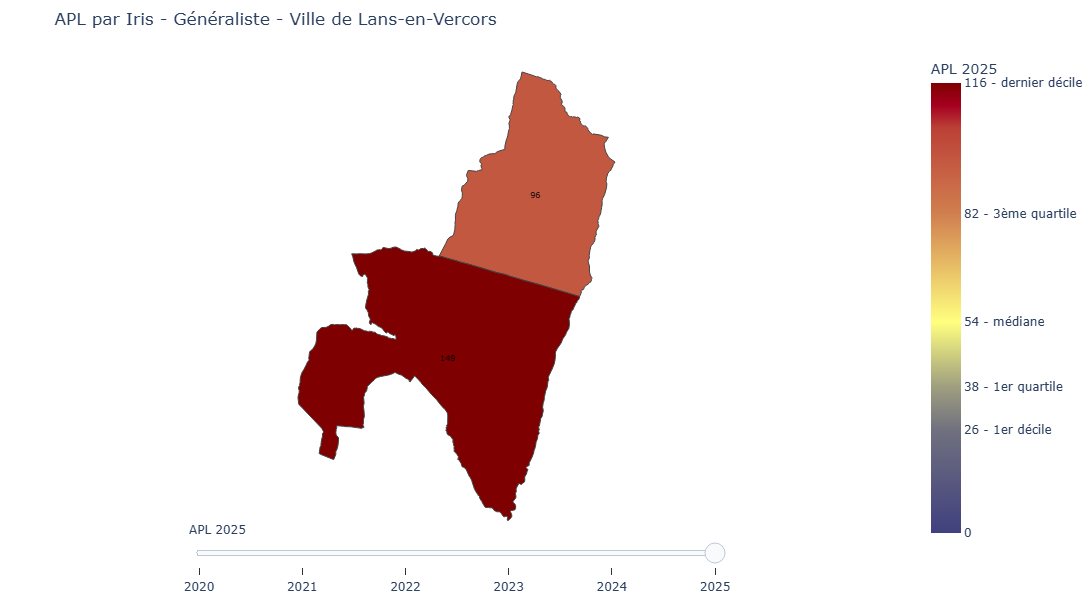

In [106]:
show_label=len(gdf) < 150
fig = go.Figure()
l=[]
l2=[]
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()
for year in years:
    gdf_year=gdf_merged[gdf_merged["year"]==year]
    l.append(
        go.Choropleth(
            visible=False,
            geojson=geojson,
            locations=gdf_year["fid"],
            z=gdf_year["apl_clip" if norm_colorbar else "apl"],
            zmin=0,
            zmax=q90s[year-years[0]] if norm_colorbar else None,
            text=gdf_year.apply(
                lambda row: f"Commune: {row["nom_commune"]}<br>Iris: {row["code_iris"]}<br>Nom Iris: {row['nom_iris']}<br>APL 20{year}: {row['apl']:.1f}<br>Variation APL/2020: {row['delta20']*100:+.0f}%<br>Médiane APL: {(row["apl"]-q50s[year-years[0]])*100/(q50s[year-years[0]]+0.001):+.0f}% ({q50s[year-years[0]]:.1f})<br>Moyenne pondérée APL: {(row["apl"]-meanws[year-years[0]])*100/(meanws[year-years[0]]+0.001):+.0f}% ({meanws[year-years[0]]:.1f})<br>Nb ETP: {row['nb']:.1f}<br>Population: {row['pop']:.0f}<br>Population ajustée: {row['pop_ajustee']:.0f}<br>Population alentour: {row['swpop']:.0f}<br>APL local: {row['R']:.1f} ({row['R']*100/(row['apl']+1e-5):.0f}% APL)",
                axis=1
            ),
            hoverinfo="text",
            showscale=True,
            colorbar={"title": f"APL 20{year}",
                      "tickvals": [0, q10s[year-years[0]], q25s[year-years[0]], q50s[year-years[0]], q75s[year-years[0]], q90s[year-years[0]]] if norm_colorbar else None,
                      "ticktext": ['0', f'{q10s[year-years[0]]:.0f} - 1er décile', f'{q25s[year-years[0]]:.0f} - 1er quartile', f'{q50s[year-years[0]]:.0f} - médiane', f'{q75s[year-years[0]]:.0f} - 3ème quartile', f'{q90s[year-years[0]]:.0f} - dernier décile'] if norm_colorbar else None,
                     },
            colorscale=[[0.0, "rgb(64,64,127)"],
                        [q10s[year-years[0]]*1.0/q90s[year-years[0]] if norm_colorbar else 0.1, "rgb(112,112,127)"],
                        [q25s[year-years[0]]*1.0/q90s[year-years[0]] if norm_colorbar else 0.25, "rgb(159,159,127)"],
                        [q50s[year-years[0]]*1.0/q90s[year-years[0]] if norm_colorbar else 0.50, "rgb(255,255,127)"],
                        [q75s[year-years[0]]*1.0/q90s[year-years[0]] if norm_colorbar else 0.75, "rgb(209,127,79)"],
                        [0.90, "rgb(187,64,55)"],
                        [0.95, "rgb(165,0,32)"],
                        [1.0, "rgb(127,0,0)"]
                       ]
        ))
    if show_label:
        l2.append(
            go.Scattergeo(
                lon=gdf_year["lon"],
                lat=gdf_year["lat"],
                text=gdf_year["pretty"].astype(str),
                mode="text",
                textfont=dict(color="black", size=8),
                hoverinfo="skip",
                showlegend=False,
                visible=False,
                marker=dict(
                        color='#99ff99',
                        size=8,
                        line=dict(
                            color='#006600',
                            width=2
                        )
                    ),
            ))
fig = go.Figure(data=l+l2)   
fig.data[-1].visible = True
if show_label:
    fig.data[len(l)-1].visible = True
steps = []
i=0
for year in years:
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
             ],
        label=f"20{year}",
    )
    step["args"][0]["visible"][i] = True
    if show_label:
        step["args"][0]["visible"][i+len(l)] = True
    steps.append(step)
    i+=1

sliders = [dict(
    active=len(years)-1,
    currentvalue={"prefix": "APL ", "visible":True},
    steps=steps,
    transition={'duration': 300, 'easing': 'cubic-in-out'},
    pad=dict(l=0, r=0, t=0, b=10),
    len=0.6,
    x=0.2,
    y=0.05,
)]

fig.update_layout(
    sliders=sliders,
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        # center_lon=center_lon,
        # center_lat=center_lat,
        # lonaxis_range=(center_lon-0.1, center_lon+0.1),
        # lataxis_range=(center_lat-0.1, center_lat+0.1),
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False,
    ),
    title=f"APL par Iris - {spe_df.loc[specialite]["label_long"]} - {"Ville de" if len(code_commune) != 3 else "Département"} {commune_nom if len(code_commune) != 3 else code_commune[:-1]}",
    # height=1000,
    # width=1200,
    height=600,
    # width=2000,  
    autosize=False,
    margin=dict(l=10, r=0, t=50, b=10),
)

fig.show()

In [107]:
gdf_merged["apl"].describe().apply("{0:.0f}".format)

count     12
mean     110
std       21
min       88
25%       92
50%      109
75%      121
max      149
Name: apl, dtype: object

In [108]:
fig.update_layout(
    height=None,
    width=None, 
    autosize=True,
    # margin=dict(l=10, r=0, t=50, b=50)
)
pio.write_html(fig, file=f"out/apl_slider_{code_commune.replace("%","")}_{source}_{time}_{time_type}_{aexp}{'' if norm_colorbar else '_nonorm'}_{spe_df.loc[specialite].iloc[0]}.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})

AttributeError: 'list' object has no attribute 'replace'